# Покретни просек

У овој лекцији циљ нам је да се позабавимо „скакутањем“ вредности из године у годину, које смо имали прилике да видимо на графицима у претходној лекцији уз помоћ *покретног просека*. Подсетимо се израчунатих промена у нивоу акустичности и плесозовности музике током времена:

<img src="muzika slike/Dzez_Pop_akusticnost_razigranost.png"
     alt="Markdown Monster icon"
     width='700' />

Као што смо претходно дискутовали, на овим графицима видимо да постоје неки јаснији трендови пада и раста (када се вредности по у оси драматичније мењају), али и доста мањих варијација, поготово међу узастопним годинама (што чини да наше линије имају овај цик-цак облик). Поменути цик-цак облик нам је још уочљивији када користимо визуализације које спајају измерене вредности, али га једнако можемо приметити и када ове податке представљамо стубичастим дијаграмима, те је стога наш циљ у наставку да решимо овај *проблем*. Током протекле две године имали сте прилику да често виђате податке који имају тако честе варијације међу узастопним подацима, а онда сте можда видели и једно решење:

<img src="muzika slike/kovid_slika_google.jpg"
     width='400' />
*Извор слике: [Гугл претрага броја ковид случајева у Србији](https://www.google.com/search?q=covid+serbia+stats), принтскрин.*

На овим графицима броја ковид позитивних случајева, сви смо имали прилике да видимо да се број случајева из дана у дан мења на необичан начин. Постоје периоди драматичног раста (када креће нови талас) и пада (када ситуација креће да се стабилизује и долази до смањења броја нових случајева), али и у оквиру тих периода бројеви из дана у дан су некад већи а некад мањи од претходног дана. Један од могућих узрока у овом примеру је различит рад лабораторија које се баве тестирањем узорака, па тако број позитивних тестова варира више као последица дана у недељи и радних навика, а не због неких специфичности ширења вируса. Начин на који су те мале дневне варијације комепнзоване и на претходном графику је цртање седмодневног просека (то је тамно плава линија, преко дневних вредности забележених светло плавим стубичастим дијаграмом). Ово *усредњавање* нам помаже да се поменуте варијације испеглају и тиме лакше уочавамо трендове раста и пада, односно у овом примеру лакше примећујемо периоде и трајање различитих таласа ковид пандемије.

Покретни просек (на енгл. *moving average*, *rolling average*) се често користи да се одстране брзе промене у подацима и да се лакше сагледа нека доминантија, односно дужа правилност. Поред овог ковид примера, типични примери коришћења покретног просека су у финансијама, када се посматрају промене у ценама током времена. У наставку ћемо припремити и објаснити функцију која рачуна покретни просек за временски зависне податке које смо гледали у претходној лекцији (нпр. број песама по годинама, просечна акустичност по годинама и тако даље). Ова лекција није неопходна за схватање наредних, али вам може бити од користи уколико се у будућности будете сусретали са графицима попут поменутог са ковид подацима или будете желели да своје податке анализирате уз помоћ покретног просека и тиме лакше уочите временске трендове.

In [1]:
import pandas as pd # učitavanje biblioteke za manipulaciju tabelama i nazivanje je njenom standardnom skraćenicom "pd"
import matplotlib.pyplot as plt # učitavanje bibliotke za crtanje i nazivanje je njenom standardnom skracenicom "plt"
import seaborn as sns # učitavanje biblioteke za crtanje i nazivanje je skraćeno "sns"

podaci = pd.read_csv('muzika podaci/music_data.csv') # učitavanje prethodno pripremljenog skupa podataka i čuvanje istog u promenljivoj podaci

Издвојићемо, као у претходној лекцији, песме једног жанра у посебну табелу, а затим пребројати песме тог жанра из године у годину:

In [2]:
popmuzika = podaci[podaci.Žanr=='pop'].copy() # selektujemo samo podatke za pesme pop žanra
pop_tokom_vremena = popmuzika.Godina.value_counts() # brojimo pesme pop žanra po godinama
pop_tokom_vremena = pop_tokom_vremena.sort_index()

Овакве податке смо у претходној лекцији цртали као тачкасте, линијске и стубичасте дијаграме. Овде ћемо поновити стубичасти дијаграм пре него што му додамо линију покретног просека:

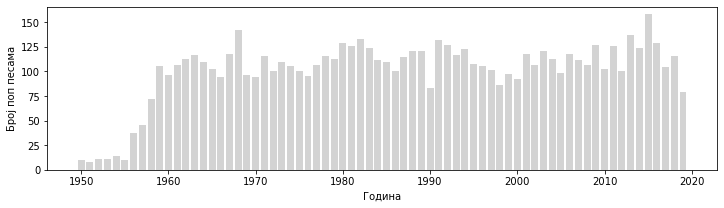

In [3]:
plt.figure(figsize=(12,3)) # dimenzije prostora na kome crtamo; odabrali smo ovaj izduženi pravougaonik zato što se stubici tako lakše vide - probajte bez ove komande
plt.bar(pop_tokom_vremena.index,pop_tokom_vremena,color='lightgrey') # stubičasti dijagram sive boje
plt.xlabel('Година') # ime x ose
plt.ylabel('Број поп песама') # ime y ose
plt.show() # prikaz grafika

Главна идеја иза покретног просека је да уместо вредности које имате из године у годину (или, у примеру са ковидом, из дана у дан) приказујете вредности које су просек последњих пар вредности (у примеру са ковидом, последњих 7 дана). Да бисмо припремили те податке, направићемо две листе – једну у којој ћемо чувати временске одреднице, а једну у којој ћемо чувати нове просечне податке.

Ако хоћемо да приказујемо средње вредности, на пример, последњих 5 година, не можемо ту вредност израчунати за прве 4 године. Зато ће листа година за које ћемо израчунати просек претходних пет година, почињати од пете године. Овако правимо ту листу:

In [4]:
vremenski_interval = 5 # interval tokom koga računamo prosek
prva_godina = min(pop_tokom_vremena.index)+vremenski_interval-1 # prva godina za koju možemo da sračunamo petogodišnji prosek, mora biti bar 5 godina veća od prve godine koju imamo u podacima
poslednja_godina = max(pop_tokom_vremena.index) # poslednja godina je najveća vrednost podataka o godinama u podacima
vreme = [t for t in range(prva_godina,poslednja_godina+1)] # lista godina počev od prve godine do poslednje godine koje smo identifikovali kao bitne
print(vreme[:5])# prikaz prvih pet godina za proveru

[1954, 1955, 1956, 1957, 1958]


У претходном блоку кôда, једна новина крије се у овој линији `vreme = [t for t in range(prva_godina,poslednja_godina+1)]`. Прочитаћемо значење ове линије: ова листа (зато што су употребљене угласте заграде) садржи `t` за свако `t` које је у опсегу (`range`) између прве и последње године које смо идентификовали као битне. Ово је једна јако Пајтон-специфична команда која краће записује кôд у наставку који сте можда чешће виђали (`for` петља и попуњавање листе додавањем односно функцијом `append`):
```
vreme = [] # prazna lista
for t in range(prva_godina,poslednja_godina+1): # za svako t u definisanom opsegu 
    vreme.append(t) # dodaj t u listu
```
Више о погодностима листа можете прочитати у [документацији](https://docs.python.org/3/tutorial/datastructures.html) или кроз овај [курс на Петљи](https://petlja.org/biblioteka/r/lekcije/TxtProgInPythonSrLat/02_console-toctree) где се можете подсетити и петљи, опсега и другх Пајтон специфичности.

Са петљом у наставку проћи ћемо кроз све године из листе `vreme` и за сваку годину ћемо срачунати просечан број поп песама издатих у претходних пар година (контролисано променљивом `vremenski_interval` чија је вредност сада 5, али ако хоћемо да променимо број година на којима рачунамо просек можемо то променити):

In [5]:
proseci = [] # prazna lista u koju ćemo dodavati proseke
for god in vreme: # za svaku godinu u okviru pripremljene liste vreme
    # kroz promenljivu uslov definišemo za koje godine hoćemo da usrednjimo podatke - sve godine u poslednjem vremenskom intervalu 
    uslov = (pop_tokom_vremena.index>god-vremenski_interval)&(pop_tokom_vremena.index<=god)
    # izdvajamo podatke koji odgovaraju uslovu i čuvamo ih u promenljivoj prosek:
    podskup = pop_tokom_vremena[uslov]
    # listu proseka dodajemo prosečnu vrednost podskupa podataka
    proseci.append(podskup.mean())
print(proseci[:5])

[10.8, 10.8, 16.6, 23.6, 35.8]


Листа `proseci` сада садржи просечне бројеве поп песама претходних 5 година, и можемо је као линију доцртати на претходно нацртани стубичасти дијаграм:

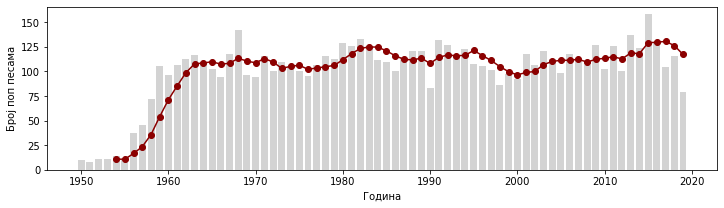

In [6]:
plt.figure(figsize=(12,3)) # dimenzije prostora na kome crtamo; odabrali smo ovaj izduženi pravougaonik zato što se stubići tako lakše vide - probajte bez ove komande
plt.bar(pop_tokom_vremena.index,pop_tokom_vremena,color='lightgrey') # stubičasti dijagram sive boje
plt.plot(vreme,proseci,color='darkred',marker='o') # novoizračunati pokretni prosek crtamo u tamno crvenoj boji
plt.xlabel('Година') # ime x ose
plt.ylabel('Број поп песама') # ime y ose
plt.show() # prikaz grafika

Тачкицама дуж линије истакли смо израчунате вредности да бисмо лако могли за сваку годину да упоредимо просек претходних пет година (тамноцрвени кружић) и број песама издатих те године (висина стубића).

Очекивано, петогодишњи просек не можемо да израчунамо за прве четири године, стога линија померајућег просека на графику креће касније, тј. први пут када је могуће израчунати просек првих 5 година. Видимо да је крива са петогодишњим просецима глаткија, тачније скоковите промене које јасно примећујемо на стубичастом дијаграму су поравнате.

Обратите пажњу на почетак тамноцрвене линије – првих десет година раста броја поп песама (од половине педесетих до половине шездесетих година прошлог века) је сада једна глатка увек растућа линија. Примећујемо у овом делу да су вредности на тамноцрвеној линији увек ниже од висина стубића. То је последица усредњавања са претходне 4 вредности – када постоји пораст у вредности, тај пораст се на овако усредњеној линији мање види. Баш та особина нам помаже да се неке краткотрајне промене (скокови и падови) ублаже, да би се јасније видели само неки трендови који се понављају дужи низ година (као на пример раст крајем седамдесетих година, или пад крајем деведесетих). Обратите пажњу и на године непосредно пре седамдесетих када, судећи по стубичастом дијаграму, постоји скок у годишњој продукцији поп песама, али се исти не види на усредњеној линији зато што се раст није одржао. Слично, на крају 1990. године, иако промене у броју песама броје и до двадесет песама, чињеница да се промене нису понављале учинила је да се ова одступања заравне и да можемо лако да сагледамо само дугорочније трендове.

Додатна последица вишегодишњег усредњавања је и кашњење у постигнутим вредностима – видите нпр. годину у којој стубичасти дијаграм први пут достигне вредности блиске 100, и када тамноцрвена линија достигне исто. 

Ово кашњење је последица избора који смо направили када смо одлучили које вредности усредњавамо. У нашим мотивационим примерима који се тичу  пандемија или промена у ценама (где се покретни просек најчешће користи) циљ је често предикција будућих вредности и трендова и стога је у тим применама типично рачунање покретног просека који се ослања само на претходне године. Са друге стране, потпуно је легитимно приступити израчунавању покретног просека у временском тренутку *t* тако што рачунамо просечну вредност и претходних и будућих вредности. На примеру петогодишњег покретног просека уместо посматрања претходних пет година, у свакој години можемо разматрати претходне две године, текућу годину и будуће две године. То је такозвани центрирани покретни просек.

Ако још мало размислимо, видећемо да заправо не постоји разлика између вредности које се усредњавају, разлика је само у временској одредници (у овом случају години) којој додељујемо израчунати просек. У случају центрираног петогодишњег покретног просека, у трећој години израчунавамо просечну вредност прве, друге, треће, четврте и пете године. То су истих пет вредности чији смо просек рачунали у петој години покретног просека који смо дискутовали и ту израчунату вредност смо на графику нацртали у петој години. Ово значи да претходно израчунате вредности покретног просека можемо померити на графику за половину дужине временског интервала и тако ћемо нацртати *центрирани* покретни просек:

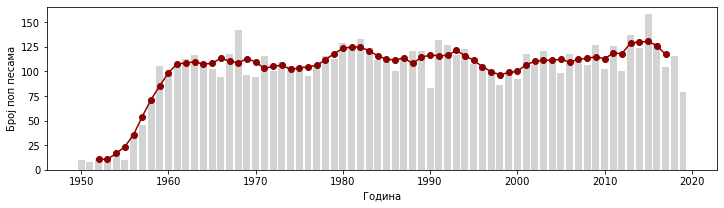

In [7]:
# centrirani pokretni prosek
vreme = [t-vremenski_interval//2 for t in vreme] # pomeranje vremenskih odrednica ulevo

# ostatak koda je isti
plt.figure(figsize=(12,3)) # dimenzije prostora na kome crtamo; odabrali smo ovaj izduženi pravougaonik zato što se stubići tako lakše vide - probajte bez ove komande
plt.bar(pop_tokom_vremena.index,pop_tokom_vremena,color='lightgrey') # stubičasti dijagram sive boje
plt.plot(vreme,proseci,color='darkred',marker='o') # novoizračunati pokretni prosek crtamo u tamno crvenoj boji
plt.xlabel('Година') # ime x ose
plt.ylabel('Број поп песама') # ime y ose
plt.show() # prikaz grafika

На овом графику више не постоји кашњење између годишњих (стубићи) и усредњених (тачкице спојене линијом) вредности. Додатно се ови графици разликују и у позицији тачака, односно временских одредница, за које немамо вредности покретног просека. Нецентрирани покретни просек нема вредности само у прве четири године, док центрирани нема вредности у прве две и последње две године. Исти број тачака недостаје само је питање њихове позиције и концептуалног размишљања о томе да ли се ослањате само на претходне или на претходне и будуће податке.

Сада ћемо рачунање покретног просека применити и на податке о музичким карактеристикама. Урадићемо то у оквиру функције коју после лако можемо примењивати на различите жанрове и музичке карактеристике. Резултат функције може бити листа просечних вредности које ћемо накнадно нацртати (као горе), али смо се ми одлучили да функција одмах и црта израчунато.

In [8]:
def grafik_pokretnog_proseka(podaci, zanr, muz_karakteristika, vremenski_interval, boja, centriranost):
    """
    Ova funkcija za odabrani žanr i muzičku karakteristiku crta grafik promene karakteristike kroz vreme
    ali se usrednjavanje ne vrši na godišnjem već na višegodišnjem nivou (definisano parametrom vremenski_interval).
    
    podaci - skup podataka koji sadrži pesme različčitih žanrova i za svaku ima vrednosti muzičkih karakteristika (akustičnost, glasnoća,itd.)
    zanr - string koji označava muzički žanr koji hoćemo da selektujemo - može biti 'pop', 'rock' itd
    muz_karakteristika - string koji označava karakteristiku koju usrednjavamo i crtamo, mora da odgovara imenu kolone u tabeli podaci (može biti 'Akustičnost', 'Plesozovnost'...)
    vremenski_interval je broj godina (int), za 1 radi isto što i groupby('Godina').mean(), za 10 crta desetogodišnji prosek
    boja - string sa imenom boje (npr.'grey') ili heks kodom ('#000000') kojom crtamo liniju izračunatog proseka
    centriranost - boolean varijabla, True ako želimo da pokretni prosek bude centriran, inače će vrednosti biti dodeljene desnom delu intervala
    """

    zanr_cirilicom = {'pop':'поп','country':'кантри','blues':'блуз','jazz':'џез','reggae':'реге','rock':'рок','hip hop':'хип хоп'}
    muz_cirilicom = {'Akustičnost':'Акустичност','Instrumentalnost':'Инструменталност',
                     'Plesozovnost':'Плесозовност','Glasnoća':'Гласноћа','Valentnost':'Валентност',
                     'Energičnost':'Енергичност'}
    
    podaci_podskup = podaci[podaci.Žanr==zanr][['Godina',muz_karakteristika]] # deo skupa podataka koji odgovoara odabranom žanru i muzičkoj karakteristici
    
    prva_godina = min(podaci_podskup.Godina)+vremenski_interval-1 # prva godina za koju možemo da sračunamo višegodišnji prosek, mora biti bar 5 godina veća od prve godine koju imamo u podacima, ako je vremenski_interval=5
    poslednja_godina = max(podaci_podskup.Godina) # poslednja godina je najveća vrednost podataka o godinama u podacima

    vreme = [t for t in range(prva_godina,poslednja_godina+1)] # lista godina od min za koju ćemo sračunati prosek do maksimalne za žanr koji posmatramo
    prosek = [] # lista u kojoj ćemo sačuvati prosečne podatke u toku odabranog vremenskog intervala
    for t in vreme: # za svaku godinu iz liste
        uslov = ((podaci_podskup.Godina)>=t-vremenski_interval)&((podaci_podskup.Godina)<t)
        podskup_t = podaci_podskup[uslov][muz_karakteristika] # izdvajamo deo podataka koji odgovara prethodnim godinama u okviru posmatranog prozora
        prosek.append(podskup_t.mean()) # računamo prosek i dodajemo u listu
    
    if centriranost: # ako crtamo centrirane pokretne proseke, vremenske odrednice, je potrebno umanjiti za polovinu dužine vremenskog intervala
        vreme = [t-vremenski_interval//2 for t in vreme]
    
    plt.plot(vreme, prosek,color=boja,label=zanr_cirilicom[zanr]+', '+str(vremenski_interval)+'-годишњи просек') # crtamo grafik
    plt.xlabel('Година') # dodajemo ime x-ose
    plt.ylabel(muz_cirilicom[muz_karakteristika]) # dodajemo ime y ose
    #return time,mean_feature # alternativno, ova funkcija bi mogla da vraća sračunate vrednosti a da izvan funkcije crtamo grafik

Можемо да испробамо рад функције на поп музици и њеној акустичности коју смо претходно анализирали:

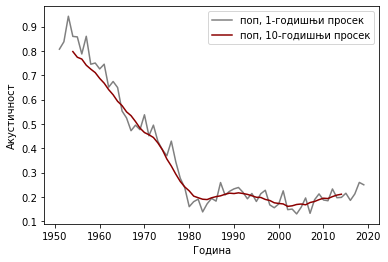

In [9]:
grafik_pokretnog_proseka(podaci,'pop','Akustičnost',1,'grey',True) # isprobavamo kreiranu funkciju za pop žanr i akustičnost, koristeći jednogodišnje usrednjavanje
#grafik_pokretnog_proseka(podaci,'pop','Akustičnost',5,'grey',True)
grafik_pokretnog_proseka(podaci,'pop','Akustičnost',10,'darkred',True) # desetogodišnje usrednjavanje
plt.legend()
plt.show()

Да тестирамо креирану функцију, испробали смо је прво на подацима са којима смо до сада радили: ниво акустичности поп музике (који смо приказали и на првој слици ове лекције). Нацртали смо једногодишњи просек (који смо у претходној лекцији цртали уз помоћ `groupby` функције, а који је сада специјални случај нове функције за вредност временског интервала од једне године) сивом бојом, и за поређење десетогодишњи просек тамноцрвеном бојом. Као и у случају броја поп песама, видимо да је и покретни просек акустичности поп песама глаткија линија, на којој лакше можемо да видимо да је до осамдесетих година акустичност била у паду, након чега је прилично стабилна, односно од тада електроника доминира поп музиком.

Сада, када имамо функцију којом једноставно цртамо глатку линију промена музичког атрибута кроз време, пробаћемо да на једном графику сагледамо све жанрове које имамо у скупу података и упоредимо их по енергичности.

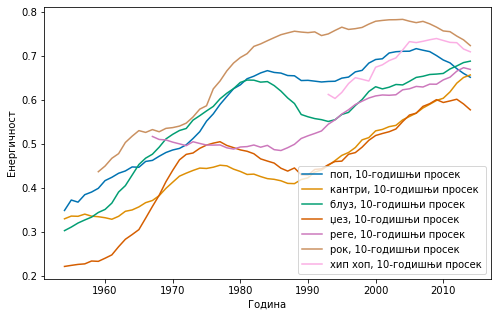

In [10]:
plt.figure(figsize=(8,5)) # definišemo veći prostor za crtanje da lakše vidimo linije i legendu grafika
i=0 # brojač koji nam pomaže da iteriramo kroz paletu boja
for zanr in podaci.Žanr.unique(): # za sve žanrove u listi jedinstvenih žanrova u našem skupu podataka
    # pozivamo funkciju za crtanje desetogodisnjeg pokretnog proseka energičnosti za svaki žanr
    grafik_pokretnog_proseka(podaci, zanr,'Energičnost',10, boja=sns.color_palette("colorblind")[i],centriranost=True) 
    i+=1 # uvećavamo brojač da iskoristimo sledeću boju za sledeći žanr

plt.legend() # legenda na grafiku

plt.show()

Примећујемо да је енергичност песама сада већа од енергичности песама током шездесетих и седамдесетих, без обзира на жанр. Видимо такође да је енергичност неких жанрова увек већа од других (упоредите на пример џез и блуз). Покретни просек нам је помогао да видимо на једном месту све жанрове и да тако лакше сагледамо да је код неких жанрова током деведесетих дошло до пада у енергичности, али је након тога у свим жанровима енергичност у порасту. Видите у наставку, на пример, график који можете добити користећи `sns.lineplot` функцију без покретног просека:

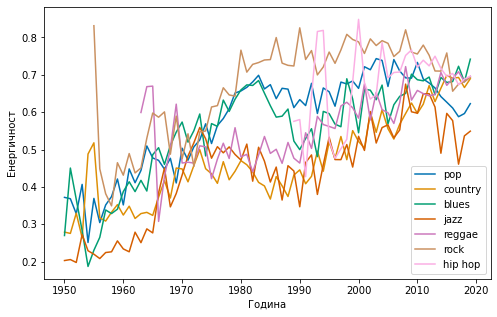

In [11]:
plt.figure(figsize=(8,5)) # definišemo prostor za crtanje, malo veći nego inače da bismo lakše pročitali legendu grafika
sns.lineplot(data = podaci, # izbor podataka koje crtamo
             x = 'Godina',y='Energičnost', # izbor kolona koje se nalaze na x i y osi
             hue='Žanr', # biramo da linije budu obojene po žanrovima
             palette="colorblind", # definišemo paletu boja za korišćenje, kao u prethodnoj svesci 
             ci=None) # ovim parametrom definišemo da se na grafiku pojave samo izračunate prosečne vrednosti, vise o tome u nastavku
plt.ylabel('Енергичност') # ime y-ose
plt.xlabel('Година') # ime x-ose
plt.legend() # legenda na grafiku

plt.show()

Без покретног просека сви жанрови имају цик-цак линије и јако је тешко испратити шта се дешава у највећем делу података које анализирамо – видимо да је рок осамдесетих најенергичнији, али не можемо тако лако наћи где је рок пре тога, а слично је и са осталим жанровима. Интересантно је такође да се у графику са покретним просеком не види да је енергичност рок музике и на самом почетку била јако висока. Проверимо о чему се ради:

In [12]:
rok_podaci = podaci[(podaci.Žanr=='rock')] # izdvajamo rok podatke i čuvamo ih u posebnu promenljivu
min_god = min(rok_podaci.Godina) # izdvajamo prvu godinu za koju imamo rok pesme
rok_podaci[rok_podaci.Godina==min_god] # prikazujemo pesme koje su izdate u prvoj godini koju imamo u podacima

,Godina,Izvođač,Naziv_pesme,Žanr,Akustičnost,Plesozovnost,Instrumentalnost,Glasnoća,Valentnost,Energičnost,Muzička_dekada
23434,1955,ronnie self,big fool,rock,0.764056,0.666414,0.000007,0.756865,0.956719,0.720712,1950s
23435,1955,ronnie self,bop-a-lena,rock,0.604417,0.587350,0.006346,0.852934,0.968054,0.941940,1950s


Обавезно послушајте ове песме ([овде](https://www.youtube.com/watch?v=7BLU0pUYWMU) и [овде](https://www.youtube.com/watch?v=4Q7jPi0gZEU)) и сами се уверите да ли су оцене о њиховим музичким карактеристикама онакве каквим их параметри приказују.

Али и поред индивидуалне оцене, оно што можемо да приметимо је да за 1955. годину постоје само 2 рок песме истог аутора, са врло високом вредношћу параметра енергичности, што је и информација коју смо приметили на цик-цак дијаграму без покретног просека. Прикажимо како се број рок песама до краја педесетих мењао:

In [13]:
rok_podaci[(rok_podaci.Muzička_dekada=='1950s')].Godina.value_counts()

1958    31
1957    28
1959    28
1956    18
1955     2
Name: Godina, dtype: int64

Видимо да је свих осталих година било више од 2 песме, стога када смо кренули да примењујемо покретни просек, ове две изузетно енергичне песме су изгубиле на значају и њихово одступање више није видљиво на графику који приказује петогодишње просеке. Ово је још једна предност покретног просека – специфичне године са мало података који одступају не могу тако драстично променити изглед графикона.

Вратимо се сада графикону покретног просека енергичности за различите жанрове. Иако смо видели пуно интересантних информација на овом графику, он и даље није претерано привлачан за посматрање нити лак за комуникацију кључних порука зато што има пуно линија и пуно боја. Боја је користан алат за издвајање различитих категорија података, али постоји лимит за њихово лако разазнавање и праћење боја. Са 7 жанрова и толико боја отежавамо читаоцу схватање порука. Када се на линијском дијаграму види прегршт линија различитих боја, то се популарно зове и „шпагети дијаграм“, енгл. *spaghetti plot*. Потражите те лоше примере да видите зашто нам је потребно да их боље решавамо, иако 7 шарених линија још увек није забрињавајуће.

Један начин да превазиђемо овај проблем је поређење мањег броја жанрова, као што смо радили на првом приказаном графику у овој лекцији. Други начин је појединачан график за сваку од линија, као што смо посматрали број песама за сваки жанр у претходној лекцији. Међутим, пажљива употреба боја може бити још једно решење:

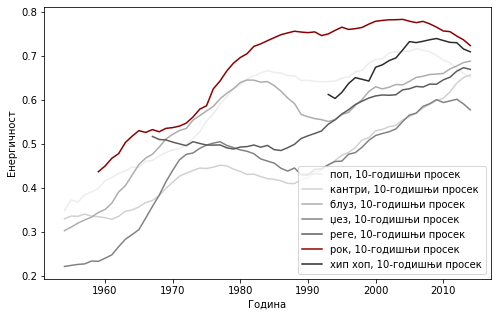

In [14]:
plt.figure(figsize=(8,5))
i=0
for zanr in podaci.Žanr.unique():
    if zanr == 'rock':
        grafik_pokretnog_proseka(podaci,zanr,'Energičnost',10,'darkred',True)
    else:
        grafik_pokretnog_proseka(podaci,zanr,'Energičnost',10,sns.color_palette('Greys')[i],True)
        i+=1
plt.legend()
plt.show()

Нијансе сиве уз једну линију коју желите да истакнете у боји често могу бити далеко ефектније решење од коришћења десет различитих боја. У илустрацији као што је ова, ми не желимо да читалац губи време и процењује енергичност сваког од жанрова, већ да истакнемо поруку да је рок све време најенергичнији жанр. То смо урадили бојењем линије која одговара рок музици тамноцрвеном бојом, док су остале линије сивим нијансама издвојене као „позадинске“, то јест оне служе да опишу контекст и распон вредности енергичности осталих жанрова, без велике потребе да се међусобно пореде и разликују.

Видели смо како да израчунамо покретни просек и како нам то помаже да на истом графику сагледамо више жанрова и промена које су се у њима дешавале током година што нам је било тешко да сагледамо на цик-цак графицима које смо претходно добијали. Приметили смо да је енергичност у порасту за већину жанрова, а остављамо вама да истражите плесозовност и гласноћа (да ли очекујете да неки жанр буде гласнији, а више за плес?). Иако смо уз помоћ просечних вредности сада лако могли да уочимо неке промене које су се дешавале током периода који посматрамо, ми смо сводили цео један жанр са пуно различитих извођача и песама на једну вредност – просечну. Питање којим ћемо се позабавити у наредној лекцији тиче се управо ове теме: да ли просек садржи довољно информација, тј. да ли је пуно песама једног жанра слично просечним вредностима или не?

<div class="alert alert-block alert-info"><img src="muzika slike/zad.png" align="left" width='70'/>Истражити како се плесозовност и гласноћа мењала по жанровима кроз време. Анализирајте промене на графицима које можете добити примењујући функцију `sns.lineplot()` и функцију `grafik_pokretnog_proseka`.</div> 

In [22]:
# # rešenje

# plt.figure(figsize=(8,5)) # definišemo veći prostor za crtanje da lakše vidimo linije i legendu grafika
# i=0 # brojač koji nam pomaže da iteriramo kroz paletu boja
# for zanr in podaci.Žanr.unique(): # za sve žanrove u listi jedinstvenih žanrova u našem skupu podataka
#     # pozivamo funkciju za crtanje desetogodisnjeg pokretnog proseka energičnosti za svaki žanr
#     grafik_pokretnog_proseka(podaci, zanr,'Glasnoća',10, boja=sns.color_palette("colorblind")[i],centriranost=True) 
#     i+=1 # uvećavamo brojač da iskoristimo sledeću boju za sledeći žanr

# plt.legend() # legenda na grafiku

# plt.show()

In [24]:
# # rešenje

# plt.figure(figsize=(8,5)) # definišemo prostor za crtanje, malo veći nego inače da bismo lakše pročitali legendu grafika
# sns.lineplot(data = podaci, # izbor podataka koje crtamo
#              x = 'Godina',y='Plesozovnost', # izbor kolona koje se nalaze na x i y osi
#              hue='Žanr', # biramo da linije budu obojene po žanrovima
#              palette="colorblind", # definišemo paletu boja za korišćenje, kao u prethodnoj svesci 
#              ci=None) # ovim parametrom definišemo da se na grafiku pojave samo izračunate prosečne vrednosti, vise o tome u nastavku
# plt.ylabel('Плесозовност') # ime y-ose
# plt.xlabel('Година') # ime x-ose
# plt.legend() # legenda na grafiku

# plt.show()

In [23]:
# # rešenje

# plt.figure(figsize=(8,5))
# i=0
# for genre in podaci.Žanr.unique():
#     if genre == 'pop':
#         grafik_pokretnog_proseka(podaci,genre,'Plesozovnost',10,'darkred',True)
#     else:
#         grafik_pokretnog_proseka(podaci,genre,'Plesozovnost',10,sns.color_palette('Greys')[i],True)
#         i+=1
        
# plt.ylim([0,1])
# plt.legend()
# plt.show()